## Import libraries and set dataset paths


In [6]:
from pathlib import Path

import datetime
from lib.dataloader import *

uav_set = Path("/home/emilia/WaterSegNet/datasets/uav_dataset/")
satelite_set = Path("/home/emilia/WaterSegNet/datasets/satelite_dataset/")
full_set = Path("/home/emilia/WaterSegNet/datasets/complete_dataset/")
# Directory paths for semantic segmentation dataset
root_dir = satelite_set

dir_test_img = root_dir / "test/images"
dir_test_mask = root_dir / "test/labels"
dir_train_img = root_dir / "train/images"
dir_train_mask = root_dir / "train/labels"
dir_valid_img = root_dir / "valid/images"
dir_valid_mask = root_dir / "valid/labels"

# Directory paths for checkpoints and best models
dir_checkpoint = root_dir / "checkpoints/"
dir_best_model = root_dir / "best_models/"
dir_best_model /= datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")


train_set = SegDataset(dir_train_img, dir_train_mask)
valid_set = SegDataset(dir_valid_img, dir_valid_mask)
test_set = SegDataset(dir_test_img, dir_test_mask)

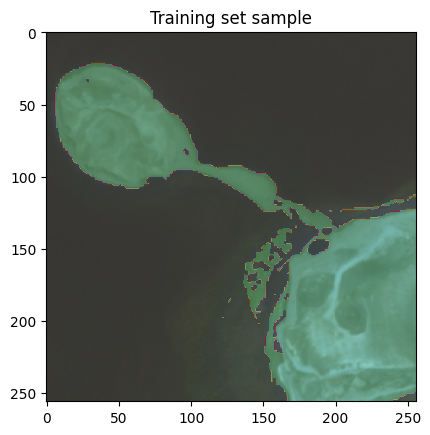

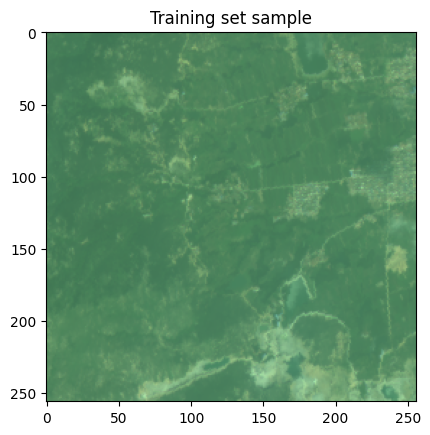

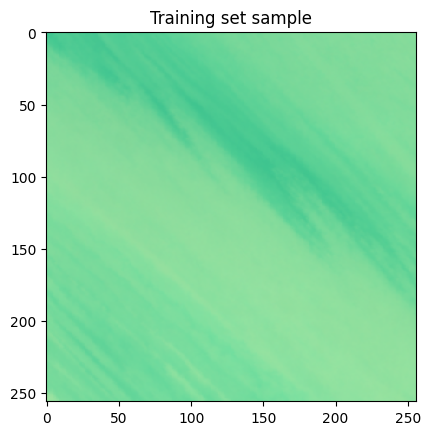

In [7]:
import matplotlib.pyplot as plt

for i in range(0, 3):
    sample = test_set[i]
    img, mask = sample["image"], sample["mask"]
    # for visualization we have to transpose back to HWC
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.imshow(mask, alpha=0.5, cmap="Accent")
    plt.title("Training set sample")
    plt.show()

## Train


In [8]:
from lib.train import *
import segmentation_models_pytorch as smp
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from segnet.SegNet_model import SegNet

model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
)


model = model.to(memory_format=torch.channels_last)

metrics = torchmetrics.MetricCollection(
    torchmetrics.Accuracy(task="binary", num_classes=1, multiclass=False),
    torchmetrics.Recall(task="binary", num_classes=1, multiclass=False),
    torchmetrics.Precision(task="binary", num_classes=1, multiclass=False),
    torchmetrics.F1Score(
        task="binary", num_classes=1, multiclass=False
    ),  # Dice Coefficient
)

train_metrics = torchmetrics.MetricTracker(metrics)
val_metrics = torchmetrics.MetricTracker(metrics)
test_metrics = torchmetrics.MetricTracker(metrics)


seg_model = SegModel(
    model,
    lr=1e-3,
    optimizer_type="adam",
    train_metrics=train_metrics,
    val_metrics=val_metrics,
    test_metrics=test_metrics,
    freeze_encoder=False,
)
data_module = SegDataModule(train_set, valid_set, test_set, batch_size=16)
model_name = "UNetPlusPlus_adam_b16"

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/satelite/",
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    filename="model-{}".format(model_name),
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, verbose=True, mode="min"
)

tb_logger = TensorBoardLogger("lightning_logs/satelite/", name=model_name)

trainer = Trainer(
    max_epochs=200,
    gpus=1 if torch.cuda.is_available() else 0,
    callbacks=[checkpoint_callback, early_stopping],
    logger=tb_logger,
    precision=16,  # Mixed precision training
)

trainer.fit(seg_model, data_module)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type              | Params
-----------------------------------------------------------
0 | model                | UnetPlusPlus      | 26.1 M
1 | criterion            | BCEWithLogitsLoss | 0     
2 | dice_loss            | DiceLoss          | 0     
3 | train_metric_tracker | MetricTracker     | 0     
4 | val_metric_tracker   | MetricTracker     | 0     
5 | test_metric_tracker  | MetricTracker     | 0     
-----------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
52.157    Total estimated model params size (MB)
/home/emilia/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /home/emilia/WaterSegNet/checkpoi

Epoch 0: 100%|██████████| 186/186 [00:35<00:00,  5.30it/s, loss=0.474, v_num=0]

Metric val_loss improved. New best score: 0.451


Epoch 1: 100%|██████████| 186/186 [00:40<00:00,  4.55it/s, loss=0.409, v_num=0]

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 0.357


Epoch 2: 100%|██████████| 186/186 [00:42<00:00,  4.37it/s, loss=0.338, v_num=0]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.334


Epoch 7: 100%|██████████| 186/186 [00:44<00:00,  4.21it/s, loss=0.276, v_num=0]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.317


Epoch 8: 100%|██████████| 186/186 [00:44<00:00,  4.21it/s, loss=0.278, v_num=0]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.275


Epoch 9: 100%|██████████| 186/186 [00:44<00:00,  4.18it/s, loss=0.308, v_num=0]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.240


Epoch 14: 100%|██████████| 186/186 [00:44<00:00,  4.20it/s, loss=0.216, v_num=0]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.211


Epoch 17: 100%|██████████| 186/186 [00:43<00:00,  4.30it/s, loss=0.234, v_num=0]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.211


Epoch 19: 100%|██████████| 186/186 [00:45<00:00,  4.08it/s, loss=0.169, v_num=0]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.189


Epoch 24: 100%|██████████| 186/186 [00:43<00:00,  4.23it/s, loss=0.141, v_num=0]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.183


Epoch 28: 100%|██████████| 186/186 [00:43<00:00,  4.28it/s, loss=0.153, v_num=0]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.163


Epoch 34: 100%|██████████| 186/186 [00:44<00:00,  4.18it/s, loss=0.121, v_num=0] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.162


Epoch 37: 100%|██████████| 186/186 [00:46<00:00,  4.01it/s, loss=0.131, v_num=0]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.159


Epoch 41: 100%|██████████| 186/186 [00:43<00:00,  4.25it/s, loss=0.0874, v_num=0]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.151


Epoch 47: 100%|██████████| 186/186 [00:43<00:00,  4.23it/s, loss=0.0784, v_num=0]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.146


Epoch 57: 100%|██████████| 186/186 [00:43<00:00,  4.32it/s, loss=0.075, v_num=0] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.146. Signaling Trainer to stop.


Epoch 57: 100%|██████████| 186/186 [00:43<00:00,  4.32it/s, loss=0.075, v_num=0]


In [4]:
%load_ext tensorboard

In [5]:
torch.cuda.empty_cache()

In [6]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   2048 B   |   3565 MiB |  22461 GiB |  22461 GiB |\n|       from large pool |      0 B   |   3555 MiB |  22350 GiB |  22350 GiB |\n|       from small pool |   2048 B   |     30 MiB |    110 GiB |    110 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   2048 B   |   3565 MiB |  22461 GiB |  22461 GiB |\n|       from large pool |      0 B   |   3555 MiB |